In [2]:
import numpy as np 
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image
import gdown
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns

In [2]:
#Used for data augmentation (horizontal flip). The archive is already downloaded with the images

#import glob
#db_path = "Gender Recognition Images/"
#woman = [cv2.imread(file) for file in glob.glob(db_path+"woman/*.*")]
#for n in range(len(woman)):
#    cv2.imwrite("C:/Users/Nicho/OneDrive/Desktop/UNI/MAGISTRALE/Visione Artificiale/FER-and-GR-Project/Gender Recognition Images/woman/w{}.jpg".format(n),cv2.flip(woman[n],1))

In [3]:
file_path = "test.zip"
if not os.path.exists("Gender Recognition Images/"):
    gdown.download("https://drive.google.com/uc?id=1d-rWM32nIGUmEz7tCTNtA10mQLkxMyk2", file_path)
    gdown.extractall(file_path)
    if os.path.exists(file_path):
        os.remove(file_path)

In [4]:
db_path = "Gender Recognition Images/"
batch_size = 128
num_classes = 2
img_height = 378
img_width = 378

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(db_path,
                                                               validation_split=0.25,
                                                               subset="training",
                                                               seed=0,
                                                               label_mode = 'int',
                                                               color_mode='grayscale',
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(db_path,
                                                               validation_split=0.25,
                                                               subset="validation",
                                                               seed=0,
                                                               label_mode = 'int',
                                                               color_mode='grayscale',
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)


Found 30830 files belonging to 2 classes.
Using 23123 files for training.
Found 30830 files belonging to 2 classes.
Using 7707 files for validation.


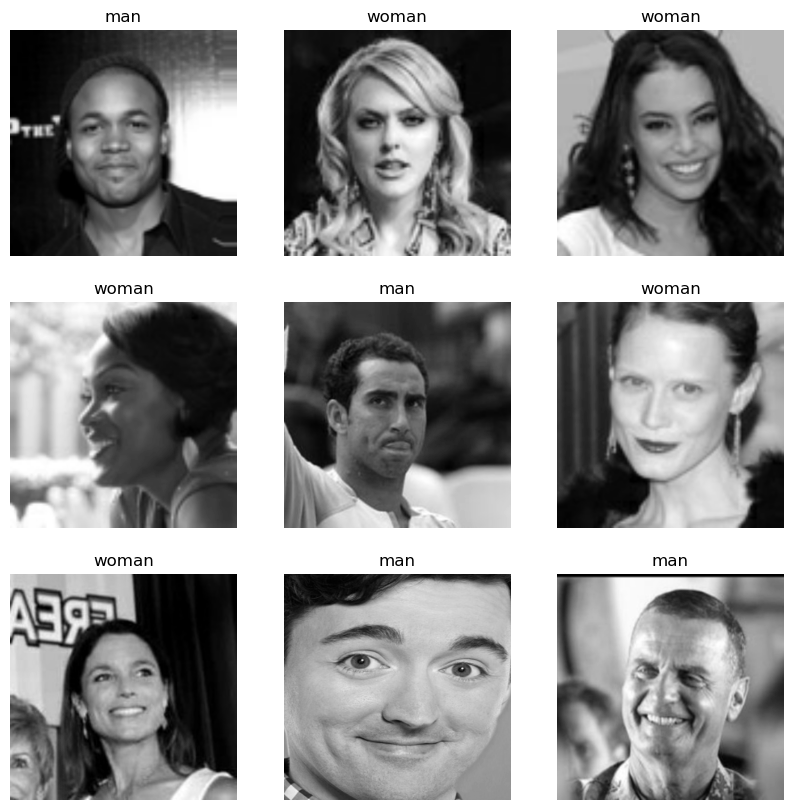

In [9]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        ax.imshow(images[i].numpy().astype("uint8")[:,:,0], cmap="gray")
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
# Build the Model

model = Sequential([
                  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,1)),
                  layers.Conv2D(32, 3, padding='same', activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(64, 3, padding='same', activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(128, 3, padding='same', activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Dropout(0.2),
                  layers.Conv2D(256, 3, padding='same', activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Dropout(0.2),
                  layers.Conv2D(512, 3, padding='same', activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Dropout(0.2),
                  layers.Flatten(),
                  layers.Dense(256, activation='relu'),
                  layers.Dropout(0.2),  
                  layers.Dense(128, activation = 'relu'),
                  layers.Dropout(0.2),
                  layers.Dense(num_classes, activation = 'sigmoid')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3,
                                                  mode='min',
                                                  restore_best_weights=True
                                                 )
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 378, 378, 1)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 378, 378, 32)      320       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 189, 189, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 189, 189, 64)      18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 94, 94, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 94, 94, 128)      

In [67]:
# Train the model

epochs = 50
history = model.fit(train_ds, validation_data = val_ds, epochs = epochs, batch_size = batch_size, 
                    verbose = 2, callbacks=[early_stopping])

Epoch 1/50
181/181 - 211s - loss: 0.5530 - accuracy: 0.7016 - val_loss: 0.4110 - val_accuracy: 0.8130
Epoch 2/50
181/181 - 91s - loss: 0.3440 - accuracy: 0.8412 - val_loss: 0.2555 - val_accuracy: 0.8988
Epoch 3/50
181/181 - 112s - loss: 0.2322 - accuracy: 0.9011 - val_loss: 0.2075 - val_accuracy: 0.9155
Epoch 4/50
181/181 - 84s - loss: 0.1741 - accuracy: 0.9309 - val_loss: 0.1670 - val_accuracy: 0.9367
Epoch 5/50
181/181 - 84s - loss: 0.1362 - accuracy: 0.9452 - val_loss: 0.1642 - val_accuracy: 0.9381
Epoch 6/50
181/181 - 83s - loss: 0.1208 - accuracy: 0.9523 - val_loss: 0.1852 - val_accuracy: 0.9424
Epoch 7/50
181/181 - 83s - loss: 0.0932 - accuracy: 0.9635 - val_loss: 0.1845 - val_accuracy: 0.9415
Epoch 8/50
181/181 - 84s - loss: 0.0719 - accuracy: 0.9725 - val_loss: 0.2078 - val_accuracy: 0.9327


In [68]:
model_acc = model.evaluate(val_ds)[1]
model_acc

61/61 [==============================] - ETA: 44s - loss: 0.0998 - accuracy: 0.976 - ETA: 10s - loss: 0.1214 - accuracy: 0.960 - ETA: 10s - loss: 0.1413 - accuracy: 0.955 - ETA: 9s - loss: 0.1583 - accuracy: 0.957 - ETA: 9s - loss: 0.1682 - accuracy: 0.94 - ETA: 9s - loss: 0.1745 - accuracy: 0.94 - ETA: 9s - loss: 0.1738 - accuracy: 0.94 - ETA: 9s - loss: 0.1670 - accuracy: 0.94 - ETA: 8s - loss: 0.1612 - accuracy: 0.94 - ETA: 8s - loss: 0.1636 - accuracy: 0.93 - ETA: 8s - loss: 0.1727 - accuracy: 0.93 - ETA: 8s - loss: 0.1662 - accuracy: 0.94 - ETA: 8s - loss: 0.1674 - accuracy: 0.93 - ETA: 8s - loss: 0.1666 - accuracy: 0.93 - ETA: 7s - loss: 0.1782 - accuracy: 0.93 - ETA: 7s - loss: 0.1812 - accuracy: 0.93 - ETA: 7s - loss: 0.1782 - accuracy: 0.93 - ETA: 7s - loss: 0.1801 - accuracy: 0.93 - ETA: 7s - loss: 0.1847 - accuracy: 0.93 - ETA: 7s - loss: 0.1820 - accuracy: 0.93 - ETA: 6s - loss: 0.1806 - accuracy: 0.93 - ETA: 6s - loss: 0.1843 - accuracy: 0.93 - ETA: 6s - loss: 0.1820 - acc

0.9381082057952881

In [69]:
# Save the Model

model.save('Gender Model/')

INFO:tensorflow:Assets written to: Gender Model/assets


In [14]:
gender_model = keras.models.load_model('Gender Model/')
testData = tf.keras.preprocessing.image_dataset_from_directory(
    "Test Set/Gender",
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    seed=123456,
    image_size=(img_height,img_width),
    batch_size=1000)


predictions = np.array([])
labels =  np.array([])
for x, y in testData:
    predictions = np.concatenate([predictions, np.argmax(gender_model.predict(x), axis = -1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

Found 436 files belonging to 2 classes.
14/14 [==============================] - 7s 466ms/step


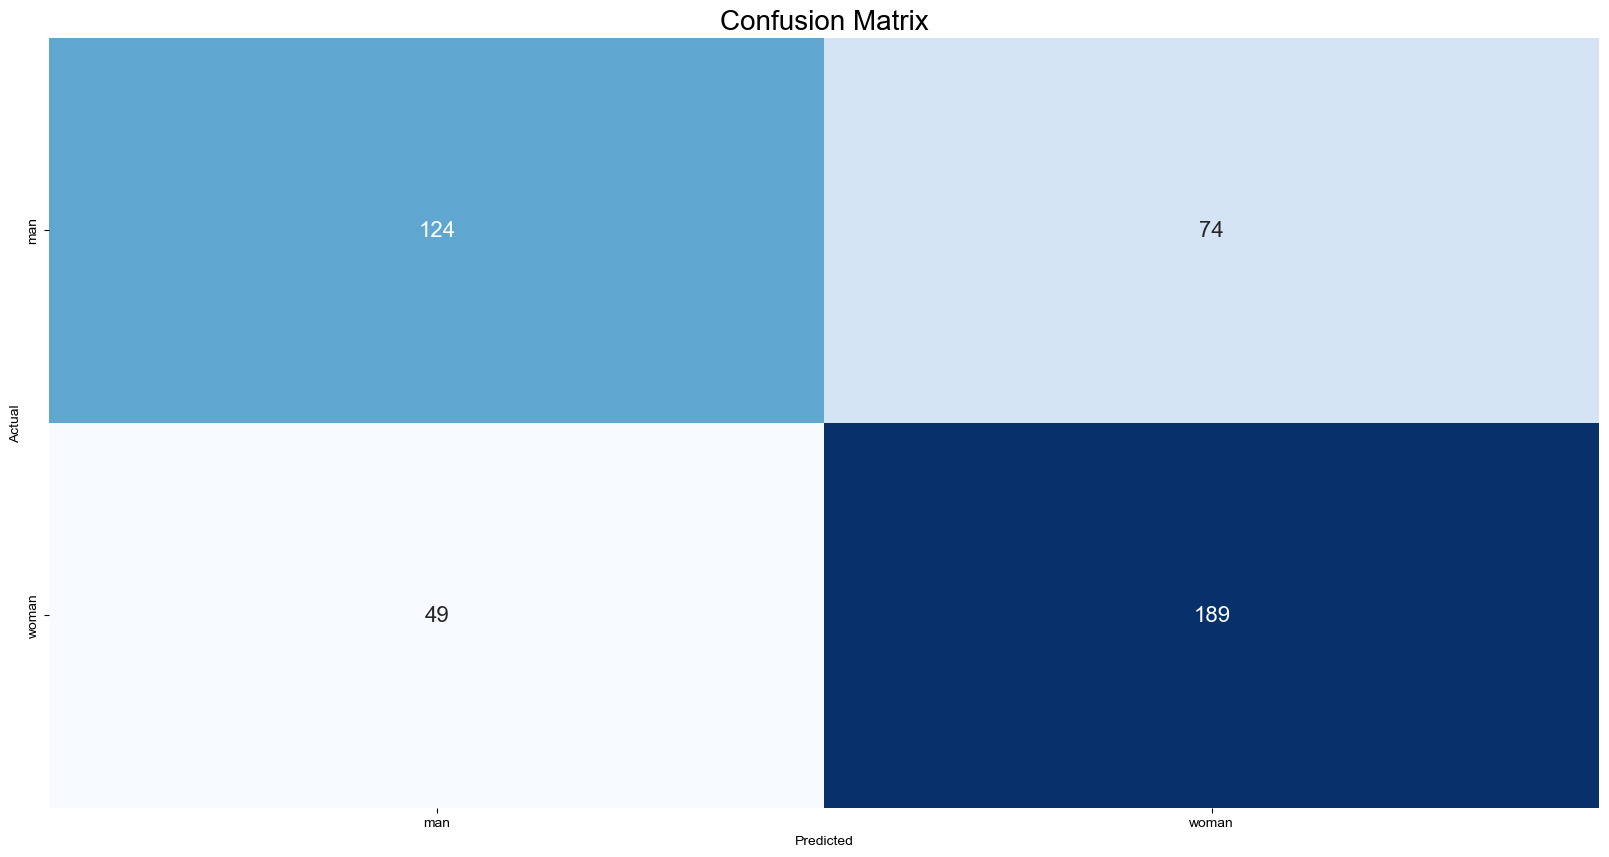

In [15]:
cm_data = confusion_matrix(labels , predictions)
cm = pd.DataFrame(cm_data, columns=class_names, index = class_names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [18]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

         0.0       0.72      0.63      0.67       198
         1.0       0.72      0.79      0.75       238

    accuracy                           0.72       436
   macro avg       0.72      0.71      0.71       436
weighted avg       0.72      0.72      0.72       436

